# Préparez des données pour un organisme de santé publique

<img src="img/oc.png" width="300" height="300"/>

In [32]:
from enum import Enum
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

import re
from wordcloud import WordCloud, STOPWORDS

import scipy.stats as st

from sklearn import decomposition
from sklearn import preprocessing
from functions import *

from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

In [33]:
# afficher tout le dataset
def plot_data(df):
    '''
    Visualize the hole dataset in order to see the missing values
    Input:
        - df: DataFrame to plot
    '''
    plt.figure(figsize=(15, 10))
    sns.heatmap(df.isna(), cbar = False)
    plt.title('Entire dataset',fontsize=25)
    plt.xlabel('Variables',fontsize=15)
    plt.ylabel('Observations',fontsize=15)

In [34]:
class DensityTypes(Enum):
    Density = 1,
    Boxplot = 2

In [35]:
def plot_density(df, columns = np.NaN, dt = DensityTypes.Density):
    '''
    Used to plot density for a dataframe columns
    Input:
        df - the dataframe
        columns - a list of columns if it is nan than all the columns in the dataframe are selected
    '''
    if columns is np.NaN:
        columns = df.select_dtypes(include=np.number).columns
    
    fig, axes = plt.subplots(round(len(columns)/2+.1), 2, figsize=(30, 15), constrained_layout=True);
    
    on_col=0
    on_line=0
    for index, col in enumerate(columns):
        if (dt == DensityTypes.Density):
            sns.distplot(df[col], label=col, ax=axes[on_line, on_col%2], bins=100);
        elif (dt == DensityTypes.Boxplot):
            sns.boxplot(df[col], ax=axes[on_line, on_col%2]);
        #sns.histplot(df[col], kde=True, stat="density", linewidth=0, ax=axes[on_line, on_col%2])
        #axes[on_line, on_col%2].set_title('{0} distribution'.format(col,fontsize=25));
        axes[on_line, on_col%2].set_xlabel(col, fontsize=15);
        axes[on_line, on_col%2].set_ylabel('Density', fontsize=15);
        if on_col%2 == 1: on_line+=1
        on_col+=1;
    plt.show();


In [138]:
def plot_words(df, col):
    # Remove punctuation
    
    df[col].map(lambda x: re.sub('[,\.!?]', '', x))

    # Convert the titles to lowercase
    
    df[col].map(lambda x: x.lower())

    # Print out the first rows of papers
    df[col].head()


    # Join the different processed titles together.
    long_string = ','.join(list(df[col].values))
    # Create a WordCloud object
    wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')# Generate a word cloud
    wordcloud.generate(long_string)# Visualize the word cloud
    plt.figure( figsize=(15,10) )
    plt.imshow(wordcloud)
    plt.show()

In [149]:
def compute_words_freq(df, var, sep=None):
    var_new = var + '_new'
    # compute function most common wolrd
    if sep is None:
        # make counting for each word
        df[var_new] = df[var].str.lower().str.replace('[^\w\s]','') 
        df_freq = df.pnns_groups_2_new.str.split(expand=True).stack().value_counts().reset_index()
    else:
        # make counting for each sequances of worlds separated by sep for example ','
        df[var_new] = df[var].str.lower()
        df_freq = df.pnns_groups_2_new.str.split(sep,expand=True).stack().value_counts().reset_index()
    df_freq.columns = ['Word', 'Frequency'] 
    
    df.drop([var_new], inplace=True, axis=1)
    return df_freq

In [37]:
def print_columns(df):
    '''
    prints all columns 
    '''
    i=0
    for col in df.columns:
        i+=1
        print('{0}:{1}'.format(i,col))

In [38]:
def plot_correlation(df):
    corr = df.corr()
    # Fill redundant values: diagonal and upper half with NaNs 
    mask = np.zeros_like(corr, dtype=bool)
    mask[np.triu_indices_from(mask)] = True
    corr[mask] = np.nan
    return (corr
     .style
     .background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)
     .highlight_null(null_color='#f1f1f1')  # Color NaNs grey
    )

In [39]:
def get_values_of_interest(df, col):
    '''
    Used to eliminate outliers
    Input:
        - df: DataFrame
        - col: the column to analyse
    
    computes 
        min, max, med = Q2, 
        Q1-first quartile, Q3 - third quartile
        IQ = Q3 - Q1
    returns Q1-1/5*IQ<(o1, o2)<Q1+1/5*IQ
    '''
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQ = Q3 - Q1
    o1 = max(0,Q1-1.5*IQ)
    o2 = Q3+1.5*IQ
    return (o1,o2)

In [40]:
def get_pandas_catVar_numVar(df, catVar, numVar):
    modalities = list(df_selected[catVar].value_counts().index)

    groupes= {}
    for m in modalities:
        if m not in groupes:
            groupes[m] = 0;
        groupes[m] = list(df_selected[df_selected[catVar] == m][numVar]);



    labels, data = [*zip(*groupes.items())];  # 'transpose' items to parallel key, value lists

    # or backwards compatable    
    labels, data = groupes.keys(), groupes.values();

    data = pd.DataFrame(data);
    data = data.T;
    data.columns = labels;
    
    return data

In [41]:
def compute_energy(proteins, carbohydrates, fat):
    # 1g of fat is 39 kJ and 1g of carbohydrates or proteins is 17 kJ of energy .
    return 17*proteins + 17*carbohydrates + 39*fat 

def compute_nutrition_score_fr():
    return 0

def compute_nutrition_grade_fr():
    return 'a'

In [42]:
def eta_squared(df, var1, var2):
    """
    compute the correlation of a categorical variable and numerical variable
    Input:
        - df: the dataframe
        - x: categorical variable
        - y: numerical variable
    """
    X = df[var1]
    Y = df[var2]
    moyenne_y = Y.mean()
    classes = []
    for classe in X.unique():
        yi_classe = Y[X==classe]
        classes.append({'ni': len(yi_classe),
                        'moyenne_classe': yi_classe.mean()})
    
    SCT = sum([(yj-moyenne_y)**2 for yj in Y])
    SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])
    return SCE/SCT

**The data information and description** can be found on the OpenFoodData website: [OpenFood](https://world.openfoodfacts.org/)
    


## Importation des données

In [12]:
df = pd.read_csv('data/fr_openfoodfacts_products.csv', sep = '\t', encoding='utf-8', decimal='.', low_memory=False)
#df = data.copy()
df.head(5)

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
0,0000000003087,http://world-fr.openfoodfacts.org/produit/0000...,openfoodfacts-contributors,1474103866,2016-09-17T09:17:46Z,1474103893,2016-09-17T09:18:13Z,Farine de blé noir,NaN,1kg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000004530,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,14.0,14.0,NaN,NaN
2,0000000004559,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Peanuts,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
3,0000000016087,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055731,2017-03-09T10:35:31Z,1489055731,2017-03-09T10:35:31Z,Organic Salted Nut Mix,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,12.0,NaN,NaN
4,0000000016094,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055653,2017-03-09T10:34:13Z,1489055653,2017-03-09T10:34:13Z,Organic Polenta,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
# quantité des données
print('Les quantité des données')
df.shape

# regarder les type des variable
print('Les type observé pour chaque variable')
df.dtypes

print('Conté les type des variables')
df.dtypes.value_counts()

Les quantité des données


(320772, 162)

Les type observé pour chaque variable


code                        object
url                         object
creator                     object
created_t                   object
created_datetime            object
                            ...   
carbon-footprint_100g      float64
nutrition-score-fr_100g    float64
nutrition-score-uk_100g    float64
glycemic-index_100g        float64
water-hardness_100g        float64
Length: 162, dtype: object

Conté les type des variables


float64    106
object      55
string       1
dtype: int64

- **Lignes et colonnes**: 320772, 162
- **Types des variables**: qualitative: 56 quantitative: 106

## Filtering data. Cleaning data. Choosing an application.

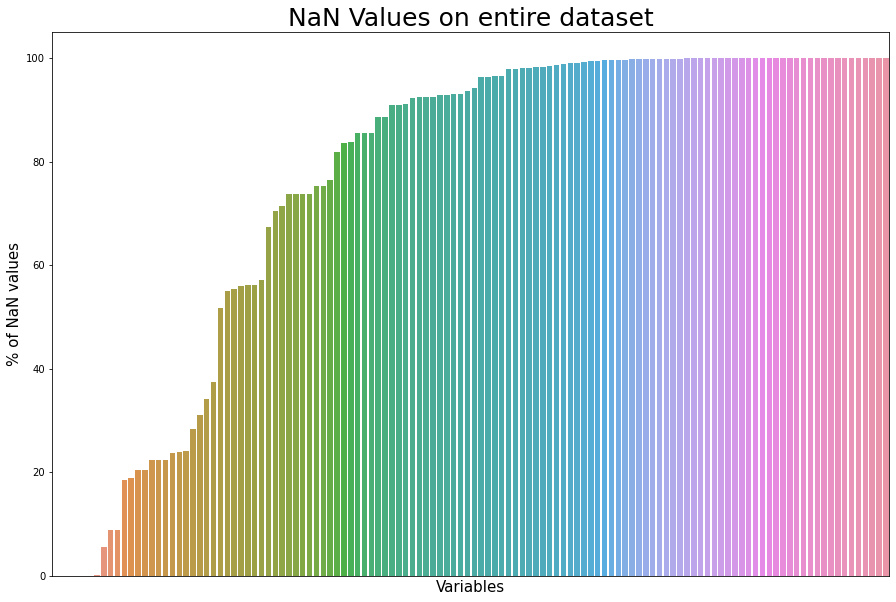

In [44]:
# verifié les valeurs manquants en affichant le pourcentage
dd = df.isna().mean().sort_values(ascending=True)*100
#plt.figure(figsize=(15, 10));
fig = plt.figure(figsize=(15, 10));
axes = sns.barplot(x=dd.values, y=dd.index, data=dd);
axes.set_xticks([]);
axes.set_yticks([0, 20, 40, 60, 80, 100]);
plt.title('NaN Values on entire dataset',fontsize=25);
plt.xlabel('Variables',fontsize=15);
plt.ylabel('% of NaN values',fontsize=15);
del dd;

***Ouufff!!!***
- 162 variables with lots of NaNs! We should try find an application and select the variables that we need!
- first for more clarity, we can see the variables that are less then 40% of NaNs and have at least two different values.

In [45]:
var_verify = (df.isna().mean() < 0.4)
#var_verify.index
columns40 = list(df.columns[var_verify])

# Choose the application idea and filter the data:

***Get less calories with higher nutrition score!***

## Description of the problem that will be considered:

When we eat and drink more calories than we use up, our bodies store the excess as body fat. If this continues, over time we may put on weight.
As a guide, an average man needs around 2,500kcal (10,500kJ) a day to maintain a healthy body weight.
For an average woman, that figure is around 2,000kcal (8,400kJ) a day.
These values can vary depending on age, size and levels of physical activity, among other factors.

Different factctors can influence on the interest in calculating the calories that we gain each day. The most important factor is when we want to loss in weight. The best way to loss in weight is a diet with sport activities. The diet also supposes a healthy eating. In this application we propose first to calculate our calories by the food that we eat and propose my be other food that can be remplaced with a better nutrition score, having the same calories or may be less.

***This are the most important features for our purpose, even that there exists other important variables in dataset.1. We use the folowing features in order to indentify the product***
1. Product information:
   - `code`
   - `creator`
   - `brands`
   - `product_name`
   - `countries_fr`
   - `ingredients_text`
   - `serving_size`
   - `additives_n`
   - `ingredients_from_palm_oil_n`                
   - `ingredients_that_may_be_from_palm_oil_n`
   - `additives_tags`
2. The nutritions value used to compute the nutri-score
   - `energy_100g`                                
   - `fat_100g`                                
   - `saturated-fat_100g`                         
   - `carbohydrates_100g`                         
   - `sugars_100g`                                
   - `fiber_100g`                                 
   - `proteins_100g`                              
   - `salt_100g`                                  
   - `sodium_100g`
   - `fruits-vegetables-nuts_100g`
3. The nutri score
   - `nutrition_grade_fr`
   - `nutrition-score-fr_100g`
   


In [95]:
selected_columns = []

if 'fruits-vegetables-nuts_100g' not in columns40:
    columns40.append('fruits-vegetables-nuts_100g') # needed to compute the nutri-score


for c in columns40:
    if not(c.endswith('_datetime')) and not(c.endswith('_t')) and not(c.endswith('_tags')):
        selected_columns.append(c)

if 'additives_tags' not in selected_columns:
    selected_columns.append('additives_tags')
    
if 'additives' in selected_columns:
    selected_columns.remove('additives')

df_selected = df[selected_columns];

## Elimination des colonnes inutiles

In [96]:
cols_to_delete = ['states', 'states_fr', 'countries', 'url'] # 'nutrition-score-uk_100g'
condition = False

for c in cols_to_delete:
    if c in df_selected.columns:
        df_selected.drop(c, inplace=True, axis=1)
    

/Users/marius/opt/anaconda3/envs/oc3/lib/python3.6/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [97]:
# quantité des données
print('Les quantité des données')
df_selected.shape

# regarder les type des variable
print('Les type observé pour chaque variable')
df_selected.dtypes

print('Conté les type des variables')
df_selected.dtypes.value_counts()

Les quantité des données


(320772, 24)

Les type observé pour chaque variable


code                                        object
creator                                     object
product_name                                object
brands                                      object
countries_fr                                string
ingredients_text                            object
serving_size                                object
additives_n                                float64
ingredients_from_palm_oil_n                float64
ingredients_that_may_be_from_palm_oil_n    float64
nutrition_grade_fr                          object
energy_100g                                float64
fat_100g                                   float64
saturated-fat_100g                         float64
carbohydrates_100g                         float64
sugars_100g                                float64
fiber_100g                                 float64
proteins_100g                              float64
salt_100g                                  float64
sodium_100g                    

Conté les type des variables


float64    15
object      8
string      1
dtype: int64

## Visualisation des données

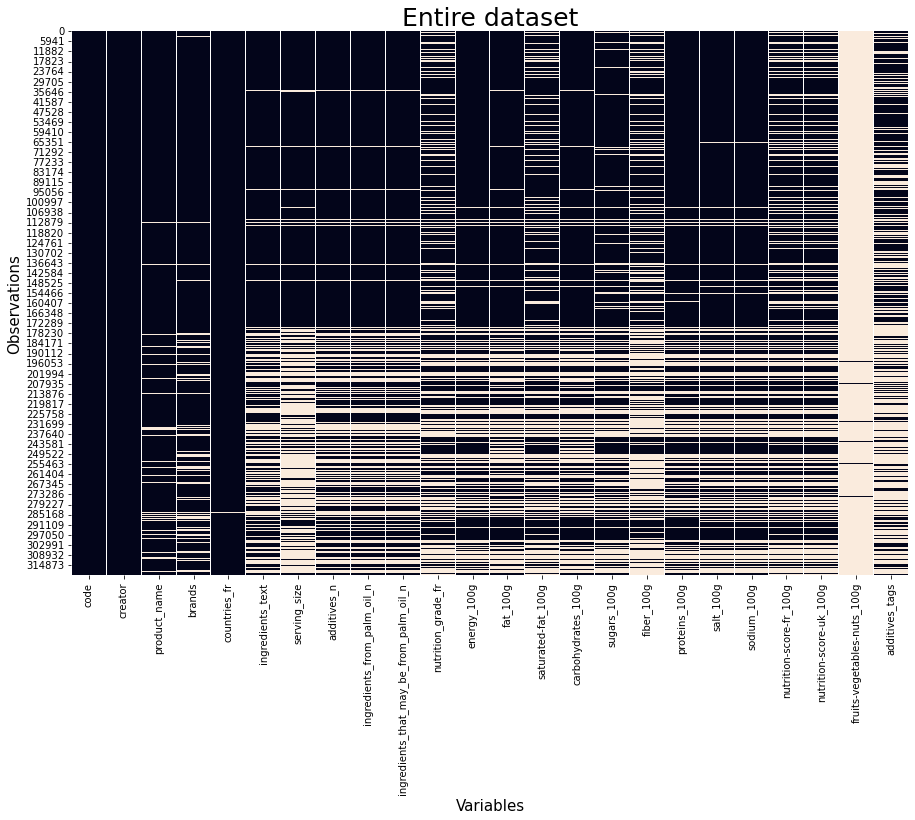

In [98]:
plot_data(df_selected)

## Describing data

In [99]:
df_selected.describe()

,additives_n,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,fruits-vegetables-nuts_100g
count,248939.000000,248939.000000,248939.000000,2.611130e+05,243891.000000,229554.000000,243588.000000,244971.000000,200886.000000,259922.000000,255510.000000,255463.000000,221210.000000,221210.000000,3036.000000
mean,1.936024,0.019659,0.055246,1.141915e+03,12.730379,5.129932,32.073981,16.003484,2.862111,7.075940,2.028624,0.798815,9.165535,9.058049,31.458587
std,2.502019,0.140524,0.269207,6.447154e+03,17.578747,8.014238,29.731719,22.327284,12.867578,8.409054,128.269454,50.504428,9.055903,9.183589,31.967918
min,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,-17.860000,-6.700000,-800.000000,0.000000,0.000000,-15.000000,-15.000000,0.000000
25%,0.000000,0.000000,0.000000,3.770000e+02,0.000000,0.000000,6.000000,1.300000,0.000000,0.700000,0.063500,0.025000,1.000000,1.000000,0.000000
50%,1.000000,0.000000,0.000000,1.100000e+03,5.000000,1.790000,20.600000,5.710000,1.500000,4.760000,0.581660,0.229000,10.000000,9.000000,23.000000
75%,3.000000,0.000000,0.000000,1.674000e+03,20.000000,7.140000,58.330000,24.000000,3.600000,10.000000,1.374140,0.541000,16.000000,16.000000,51.000000
max,31.000000,2.000000,6.000000,3.251373e+06,714.290000,550.000000,2916.670000,3520.000000,5380.000000,430.000000,64312.800000,25320.000000,40.000000,40.000000,100.000000


In [100]:
df_selected.describe(include=[object])

,code,creator,product_name,brands,ingredients_text,serving_size,nutrition_grade_fr,additives_tags
count,320749,320770,303010,292360,248962,211331,221210,154680
unique,320749,3535,221347,58784,205520,25423,5,41537
top,0735143007011,usda-ndb-import,Ice Cream,Carrefour,"Carbonated water, natural flavor.",240 ml (8 fl oz),d,en:e322
freq,1,169868,410,2978,222,5496,62763,8264


In [101]:
# afficher les valeurs unique pour chaque variable
df_selected.nunique()

code                                       320749
creator                                      3535
product_name                               221347
brands                                      58784
countries_fr                                  722
ingredients_text                           205520
serving_size                                25423
additives_n                                    31
ingredients_from_palm_oil_n                     3
ingredients_that_may_be_from_palm_oil_n         7
nutrition_grade_fr                              5
energy_100g                                  3997
fat_100g                                     3378
saturated-fat_100g                           2197
carbohydrates_100g                           5416
sugars_100g                                  4068
fiber_100g                                   1016
proteins_100g                                2503
salt_100g                                    5587
sodium_100g                                  5293


In [102]:
df_selected.isna().mean().sort_values(ascending=True)

creator                                    0.000006
code                                       0.000072
countries_fr                               0.000873
product_name                               0.055373
brands                                     0.088574
energy_100g                                0.185986
proteins_100g                              0.189699
salt_100g                                  0.203453
sodium_100g                                0.203599
ingredients_text                           0.223866
additives_n                                0.223938
ingredients_from_palm_oil_n                0.223938
ingredients_that_may_be_from_palm_oil_n    0.223938
sugars_100g                                0.236308
fat_100g                                   0.239675
carbohydrates_100g                         0.240620
saturated-fat_100g                         0.284370
nutrition_grade_fr                         0.310382
nutrition-score-uk_100g                    0.310382
nutrition-sc

# Data cleaning

## Variables quantitatives

### Elimination des ligne avec `code` NaN

In [103]:
df_selected = df_selected[~df_selected.code.isna()]

### Verification des duplicates par `code`

In [104]:
## verifié les valeurs dupliqué sur le même code
df_selected.duplicated(['code']).sum()

0

### Droping the column `code`

In [105]:
df_selected.drop(['code'], inplace=True, axis=1)

### Effacé des ligne avec le valeur nutritionistes vide

In [106]:
df_selected = df_selected[~(df_selected.energy_100g.isna() & df_selected.proteins_100g.isna() & df_selected.sugars_100g.isna() & df_selected.fat_100g.isna() &
           df_selected['saturated-fat_100g'].isna() & df_selected.fiber_100g.isna() & df_selected.sodium_100g.isna() & df_selected['fruits-vegetables-nuts_100g'].isna())]

### Outliers verifications and corrections

In [107]:
mask = ~((df_selected.fiber_100g<0) | (df_selected.fiber_100g>100) |
         (df_selected.salt_100g<0) | (df_selected.salt_100g>100) |
         (df_selected['proteins_100g']<0) | (df_selected['proteins_100g']>100) |
         (df_selected['sugars_100g']<0) | (df_selected['sugars_100g']>100)
        );
df_selected = df_selected[mask];

In [108]:
# Foods are made up of protein, fat and carbohydrate. Therefore summing them must give us not more then 100g
cols = [
    'proteins_100g',
    'fat_100g',
    'carbohydrates_100g'    
    ]   
df_selected['sum_on_g'] = df_selected[cols].abs().sum(axis=1)
df_selected['is_outlier'] = df_selected.sum_on_g>100
df_selected.is_outlier.value_counts(normalize = True)

df_selected = df_selected[df_selected.is_outlier==False];

df_selected.drop(['sum_on_g', 'is_outlier'], inplace=True, axis=1);

### Fill NaN
- _100g numerical columns set 0 within nan
- nutrition_grade_fr set from 'a' to 'e' using the knollage from nutrition-score-fr_100g 
- nutrition-score-fr_100g can be computed
- energy_100g - The process of indroducing dataset in OpenFood is difficult and complicated for example in the case of the energy the user that introduced the data could confuse kJ and kcal

In [109]:
cols = []
for col in df_selected.columns:
    if col.endswith('_100g') & ('nutrition-score' not in col) & ('nutrition-grade' not in col) & (col != 'energy_100g') :
        cols.append(col)
df_selected[cols] = df_selected[cols].fillna(value=0)

In [110]:
# 1 calorie vaut 180/43 soit 4.1860465116 Joules que nous arrondirons à 4,186 Joules.
# 1000 calories = 1 Kilocalorie = 1 kcal
df_selected['energy_100g'] = 17*df_selected.proteins_100g + 17*df_selected.carbohydrates_100g + 39*df_selected.fat_100g

### Set nutriscore outliers to NaN

In [111]:
df_selected.loc[df_selected['nutrition-score-fr_100g']<0, 'nutrition-score-fr_100g'] = np.NaN
df_selected.loc[df_selected['nutrition-score-uk_100g']<0, 'nutrition-score-uk_100g'] = np.NaN

## Variables qualitatives

### Top 5 values creation

In [112]:
take_top_5_col = ['creator', 'countries_fr']
def create_top5(df, col):
    col_5 = col + '_top5'
    ll = list(df[col].value_counts().head(5).index)
    df[col_5] = df[col]
    df.loc[~(df[col_5].isin(ll)),col_5] = 'Autre'

for col in take_top_5_col:
    create_top5(df_selected, col)
    
#df_selected.head()

### Top 10 values creation

In [113]:
take_top_10_col = ['product_name']
def create_top10(df, col):
    col_10 = col + '_top10'
    ll = list(df[col].value_counts().head(10).index)
    df[col_10] = df[col]
    df.loc[~(df[col_10].isin(ll)),col_10] = 'Autre'

for col in take_top_10_col:
    create_top10(df_selected, col)

### Split '.' in variable `ingredients`

 - character that can be found at the end of the `ingredients` (ex: 'water' and 'water.' should be the same)

In [114]:
df_selected['ingredients_text'] = df.ingredients_text.str.split('.', n=1, expand=True)[0];

### Split ':' character in `countries_fr`.`
- characted can be found in the values of `countries_fr` (ex: 'en:Tunisie' and 'Tunisie.' should be the same)

In [115]:
df_selected.countries_fr = df_selected.countries_fr.str.replace('en:', '')
df_selected.countries_fr = df_selected.countries_fr.str.replace('es:', '')
df_selected.countries_fr = df_selected.countries_fr.str.replace('de:', '')
df_selected.countries_fr = df_selected.countries_fr.str.replace('ar:', '')
df_selected.countries_fr = df_selected.countries_fr.str.replace('nl:', '')
df_selected.countries_fr = df_selected.countries_fr.str.replace('xx:', '')


df_selected.loc[(df_selected.countries_fr.str.lower() == 'royaume-uni') | (df_selected.countries_fr.str.lower() == 'Angleterre'), 'countries_fr'] = 'Royaume-Uni'
df_selected.loc[(df_selected.countries_fr.str.lower() == '77-provins') | (df_selected.countries_fr.str.lower() == 'Aix-en-provence'), 'countries_fr'] = 'France'

# Correlation

## Entre 2 variables quantitatives

In [116]:
plot_correlation(df_selected)

,additives_n,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,fruits-vegetables-nuts_100g
additives_n,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
ingredients_from_palm_oil_n,0.113376,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
ingredients_that_may_be_from_palm_oil_n,0.281352,0.182226,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
energy_100g,-0.016548,0.095022,0.018629,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
fat_100g,-0.117626,0.060381,0.017919,0.802379,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
saturated-fat_100g,-0.057006,0.093382,0.035824,0.507905,0.636419,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
carbohydrates_100g,0.161736,0.078861,0.017766,0.540972,-0.042021,-0.047544,nan,nan,nan,nan,nan,nan,nan,nan,nan
sugars_100g,0.155678,0.060772,0.004870,0.274477,-0.063760,0.063558,0.617330,nan,nan,nan,nan,nan,nan,nan,nan
fiber_100g,-0.131840,-0.002352,-0.039424,0.249919,0.095830,0.004550,0.230889,-0.017901,nan,nan,nan,nan,nan,nan,nan
proteins_100g,-0.104842,-0.007233,-0.039885,0.277584,0.213393,0.194014,-0.093323,-0.238110,0.231642,nan,nan,nan,nan,nan,nan


In [117]:
st.pearsonr(df_selected.fat_100g, df_selected.energy_100g)[0] # coefficient de correlation lineere
np.cov(df_selected.fat_100g, df_selected.energy_100g, ddof=0) # matrice de covariance 

0.8023789000889111

array([[2.91999772e+02, 1.15335422e+04],
       [1.15335422e+04, 7.07593613e+05]])

## Entre 1 variable quantitative et une variable qualitative (ANOVA)

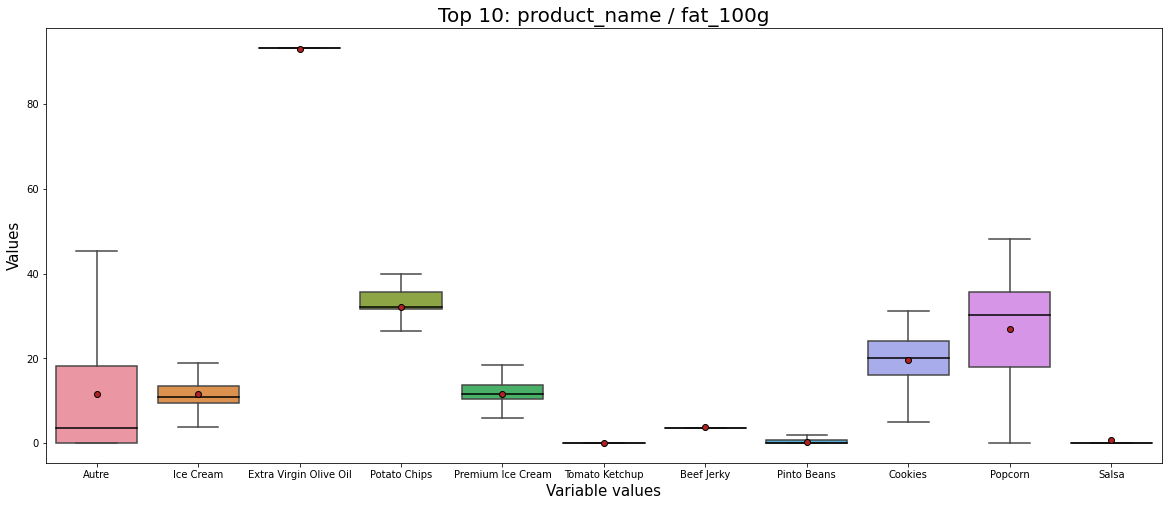

In [118]:
data = get_pandas_catVar_numVar(df, catVar = 'product_name_top10', numVar = 'fat_100g')

# Propriétés graphiques (pas très importantes)    
medianprops = {'color':"black"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}

plt.figure(figsize=(20,8));
b = sns.boxplot(x="variable", y="value", data=pd.melt(data), showfliers = False,  showmeans=True, medianprops=medianprops, meanprops=meanprops);
plt.title('Top 10: product_name / fat_100g', fontsize=20);
plt.xlabel('Variable values', fontsize=15);
plt.ylabel('Values', fontsize=15);
plt.show();

***Observons:***
- On voit ici que les fat sont très différents d'une produit à l'autre. 
- Par exemple, les fat des Potato chips, Cookies, Popcorn sont plus enlevé et plus dispersés que ceux de tomate, salsa, pinto beans.
- Le fat le plus grands est pour Extra Virgin Olive Oil ce qui est assé logique.

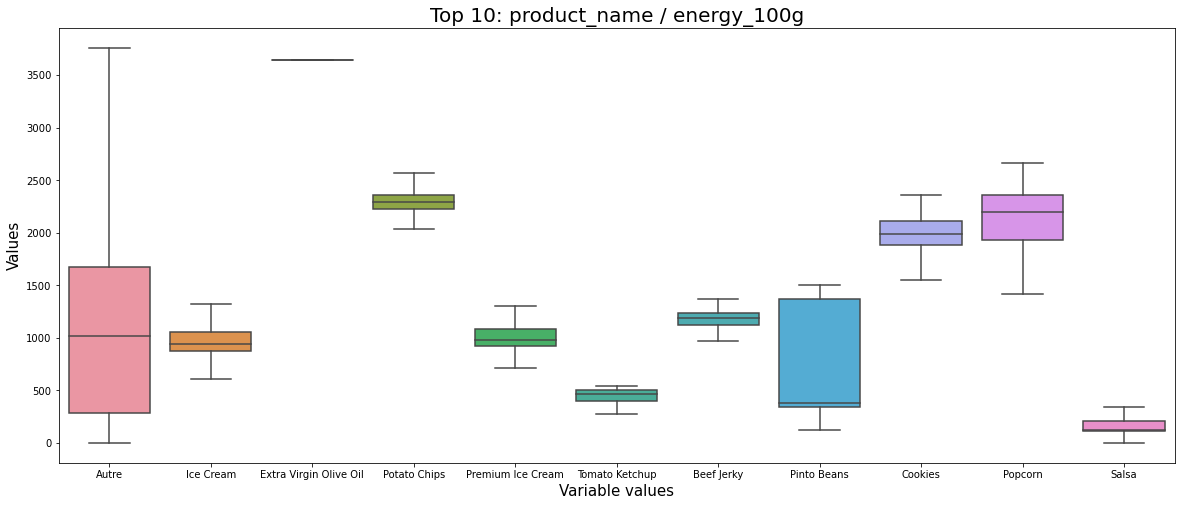

In [119]:
data = get_pandas_catVar_numVar(df, catVar = 'product_name_top10', numVar = 'energy_100g')

# Propriétés graphiques (pas très importantes)    
medianprops = {'color':"black"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}

plt.figure(figsize=(20,8));
b = sns.boxplot(x="variable", y="value", data=pd.melt(data), showfliers = False);
plt.title('Top 10: product_name / energy_100g', fontsize=20);
plt.xlabel('Variable values', fontsize=15);
plt.ylabel('Values', fontsize=15);
plt.show();

Soit Y une variable categorielle et X une variable numerique on regarde les correlation entre ces variables avec eta_squared = Variance_totale/Variance_intraclasse.
Si  eta_squared = 0, cela signifie que les moyennes par classes sont toutes égales. Il n’y a donc pas à priori de relation entre les variables Y et X. Au contraire, si eta_squared = 1, cela signifie que les moyennes par classes sont très différentes, chacune des classes étant constituée de valeurs identiques : il existe donc à priori une relation entre les variables Y et X.

In [120]:
eta_squared(df_selected, 'product_name_top10', 'energy_100g')

0.01549807432414869

In [121]:
eta_squared(df_selected, 'product_name_top10', 'fat_100g')

0.029213633935751313

## Entre 2 variables qualitatives

***Avez vous les même produits dans differents états?***

In [122]:
X = "product_name_top10"
Y = "countries_fr_top5"

cont = df_selected[[X,Y]].pivot_table(index=X,columns=Y,aggfunc=len,margins=True,margins_name="Total")

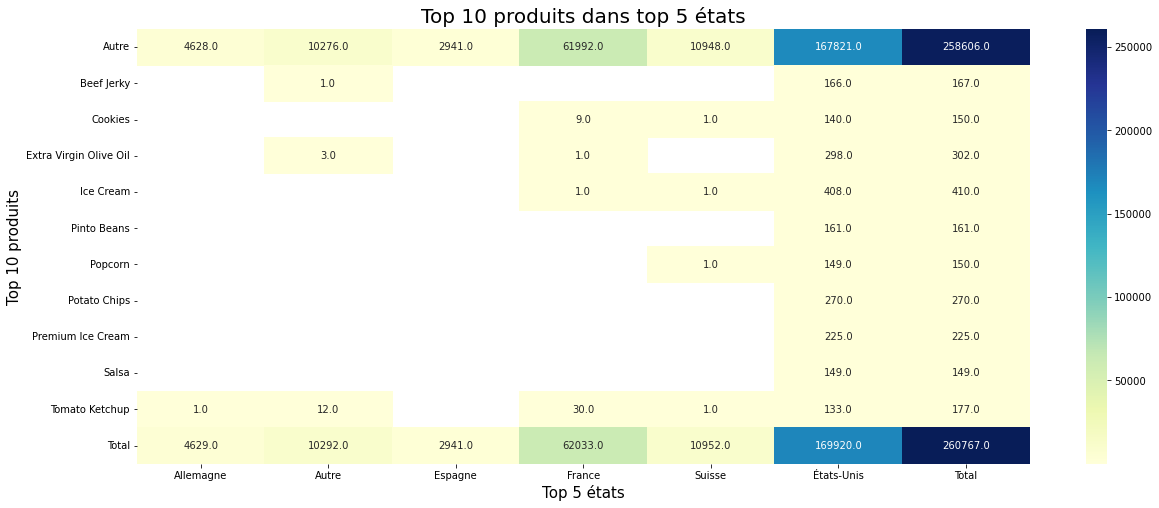

In [123]:
plt.figure(figsize=(20,8));
sns.heatmap(cont, cmap="YlGnBu", annot=True, fmt='.1f')
plt.title('Top 10 produits dans top 5 états', fontsize=20);
plt.xlabel('Top 5 états', fontsize=15);
plt.ylabel('Top 10 produits', fontsize=15);

# Analyse des données

## Analyse univarié
### Densité des variables nutritionelle

/Users/marius/opt/anaconda3/envs/oc3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/marius/opt/anaconda3/envs/oc3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/marius/opt/anaconda3/envs/oc3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or mis

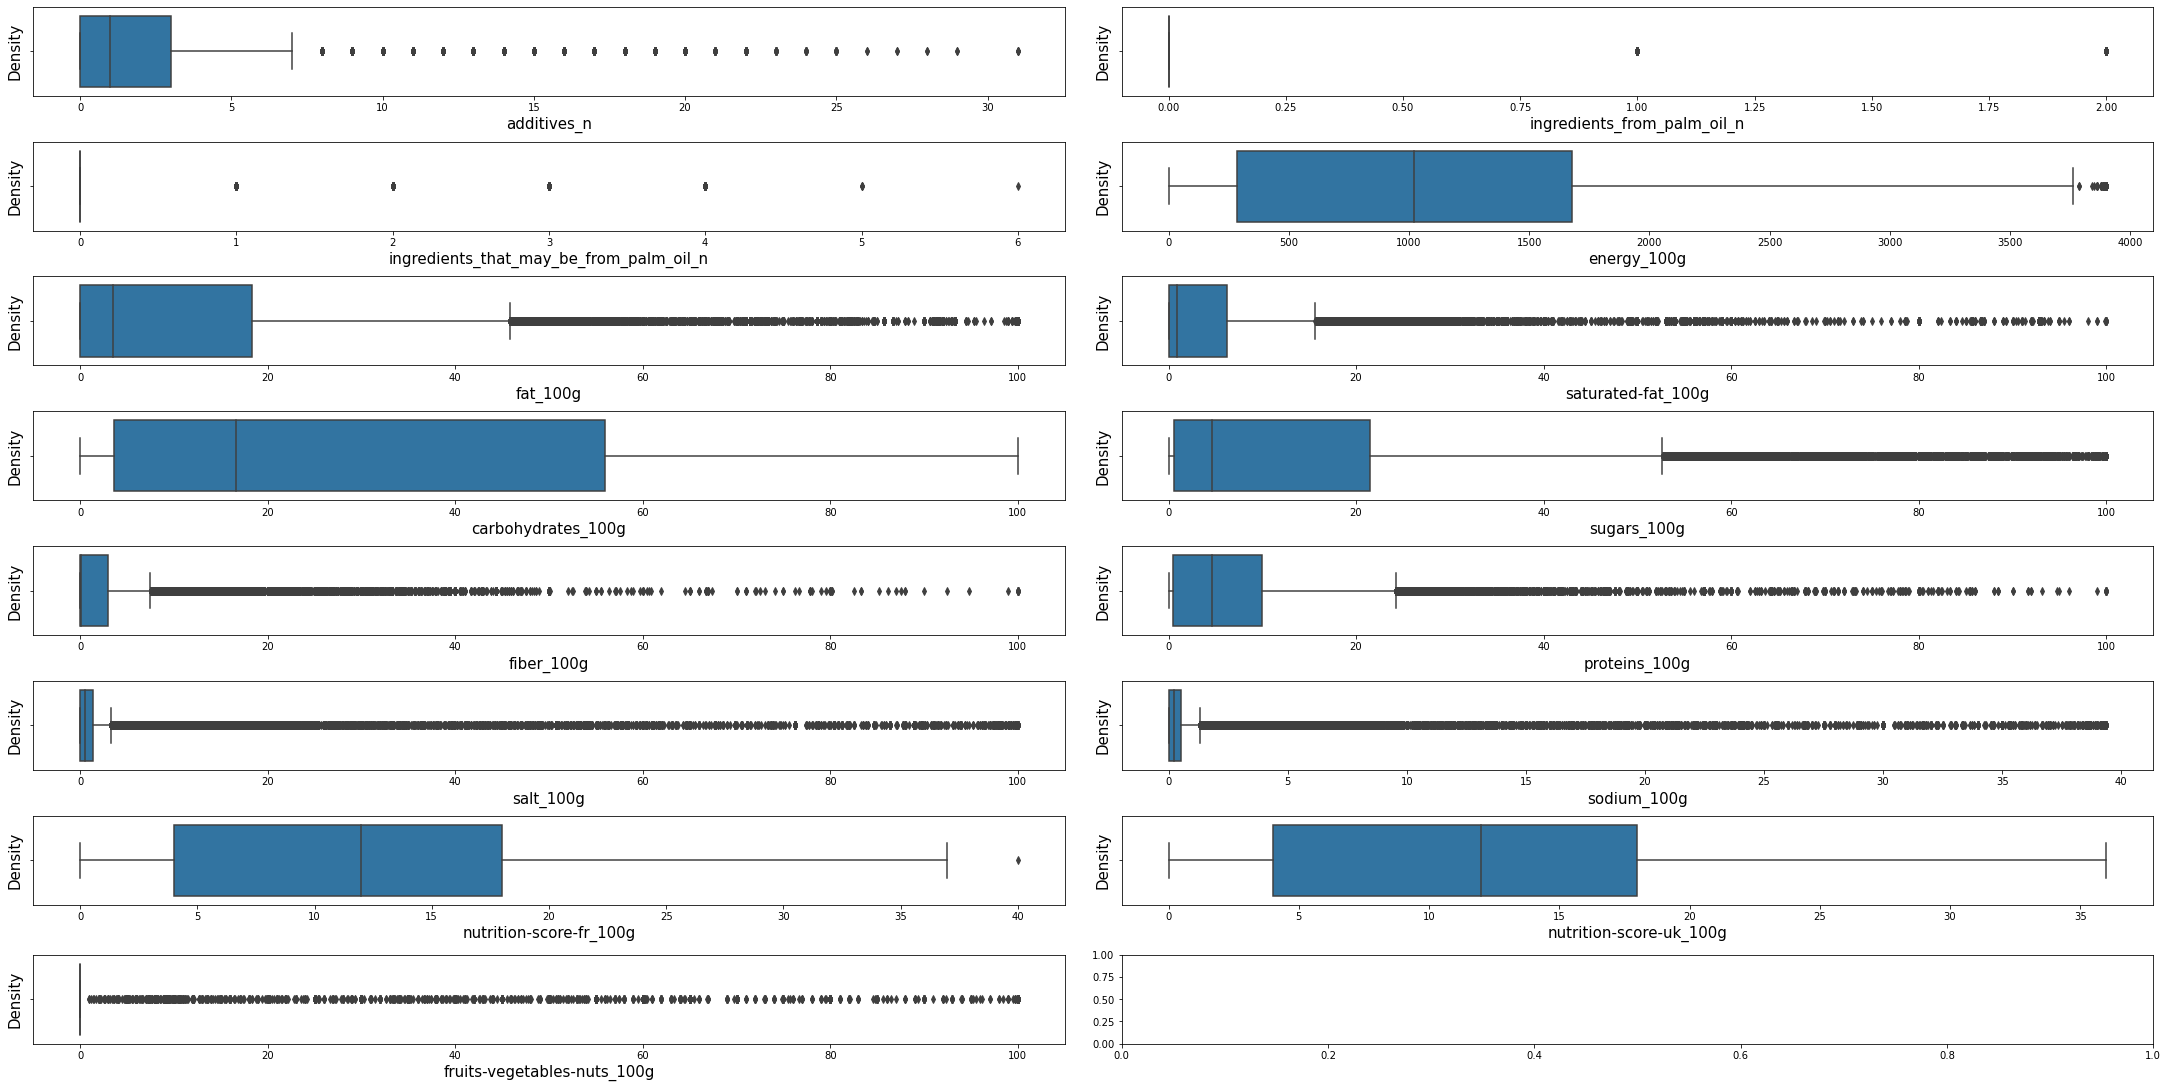

In [124]:
#plot_density(df_selected, dt = DensityTypes.Density)
plot_density(df_selected, dt = DensityTypes.Boxplot)

### Top 5 creators

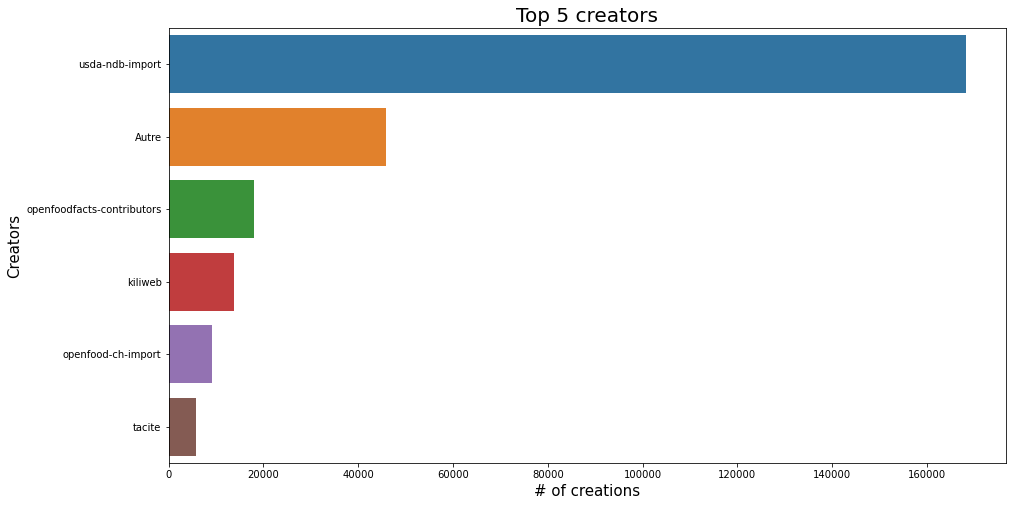

In [125]:
plt.figure(figsize=(15,8))
sns.barplot(x=df_selected.creator_top5.value_counts(), y=df_selected.creator_top5.value_counts().index, data=df_selected);
plt.title('Top 5 creators', fontsize=20);
plt.xlabel('# of creations', fontsize=15);
plt.ylabel('Creators', fontsize=15);
plt.show();

### Top 10 produits

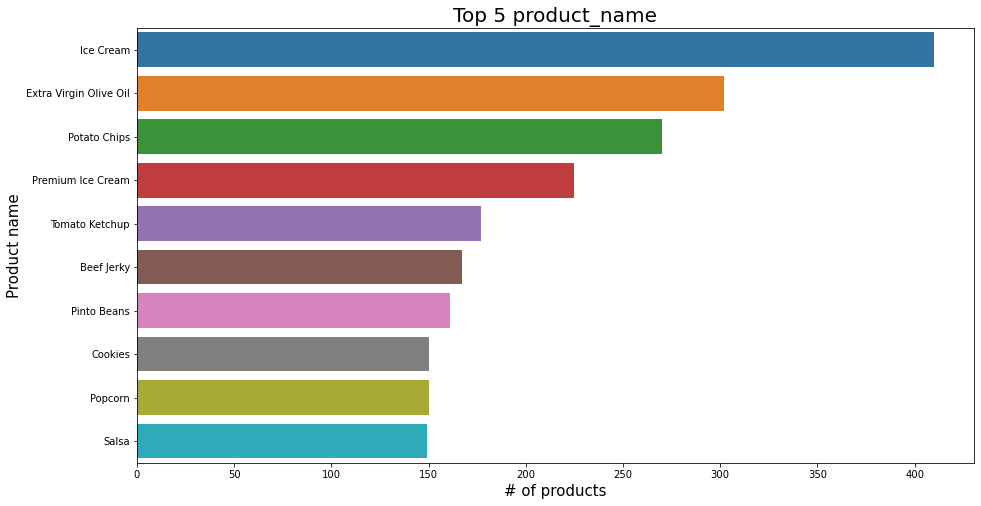

In [126]:
plt.figure(figsize=(15,8))
sns.barplot(x=df_selected.product_name.value_counts().head(10), y=df_selected.product_name.value_counts().head(10).index, data=df_selected);
plt.title('Top 5 product_name', fontsize=20);
plt.xlabel('# of products', fontsize=15);
plt.ylabel('Product name', fontsize=15);
plt.show();

### Top 10 brands

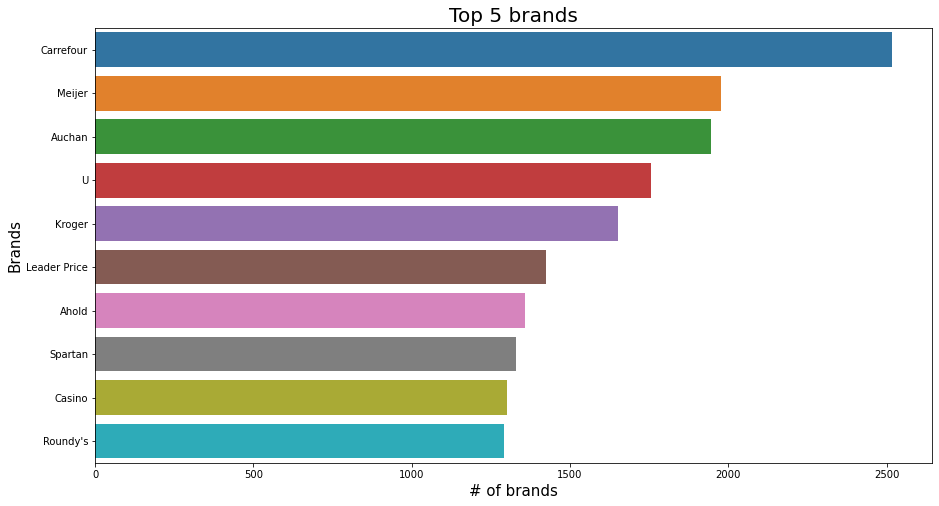

In [127]:
plt.figure(figsize=(15,8))
sns.barplot(x=df_selected.brands.value_counts().head(10), y=df_selected.brands.value_counts().head(10).index, data=df_selected);
plt.title('Top 5 brands', fontsize=20);
plt.xlabel('# of brands', fontsize=15);
plt.ylabel('Brands', fontsize=15);
plt.show();

### Top 10 ingredients

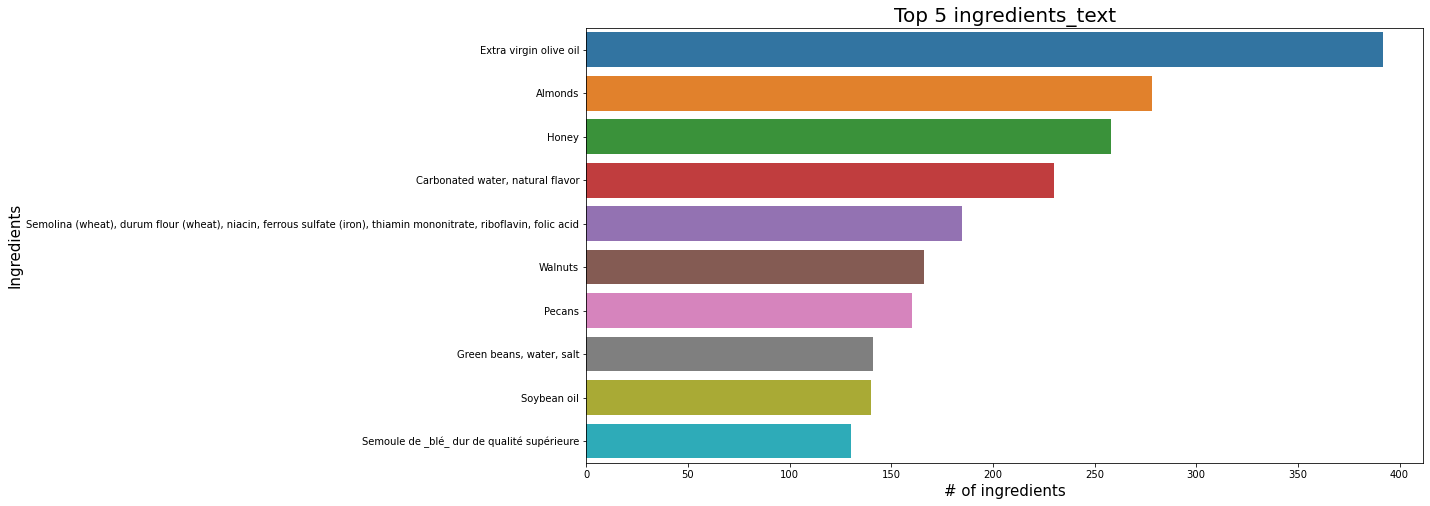

In [128]:
plt.figure(figsize=(15,8))
sns.barplot(x=df_selected.ingredients_text.value_counts().head(10), y=df_selected.ingredients_text.value_counts().head(10).index, data=df_selected);
plt.title('Top 5 ingredients_text', fontsize=20);
plt.xlabel('# of ingredients', fontsize=15);
plt.ylabel('Ingredients', fontsize=15);
plt.show();

### Top 10 additives

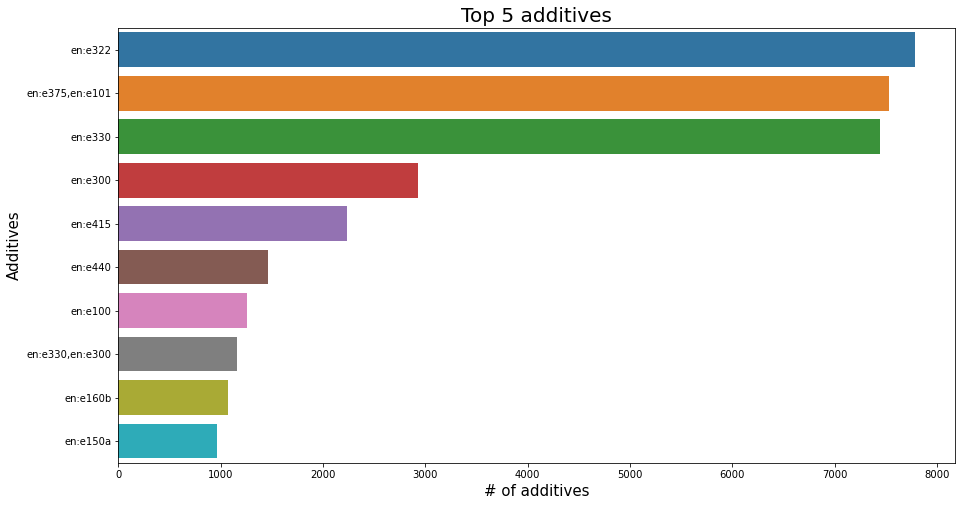

In [129]:
plt.figure(figsize=(15,8))
sns.barplot(x=df_selected.additives_tags.value_counts().head(10), y=df_selected.additives_tags.value_counts().head(10).index, data=df_selected);
plt.title('Top 5 additives', fontsize=20);
plt.xlabel('# of additives', fontsize=15);
plt.ylabel('Additives', fontsize=15);
plt.show();

### Top 10 pays

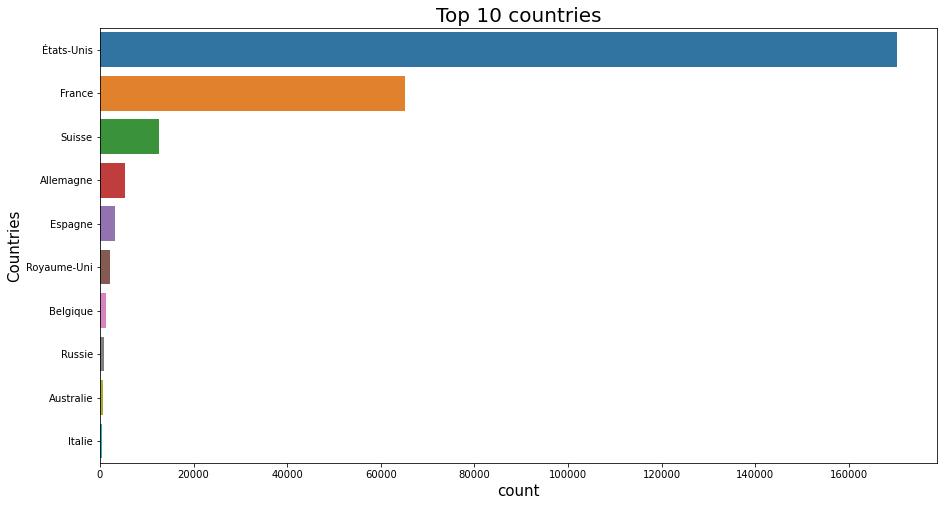

In [130]:
df1 =  df_selected.countries_fr.str.split(',', expand=True).melt(var_name='columns', value_name='values');
df2 = pd.crosstab(index=df1['values'], columns=df1['columns'], margins=True).All.drop('All').sort_values(ascending = False).head(10);
df2 = df2.to_frame();
#Using reset_index, inplace=True
df2.reset_index(inplace=True);

plt.figure(figsize=(15,8));
sns.barplot(y='values', x='All', data=df2);
plt.title('Top 10 countries', fontsize=20);
plt.xlabel('count', fontsize=15);
plt.ylabel('Countries', fontsize=15);
plt.show();

del df1, df2;

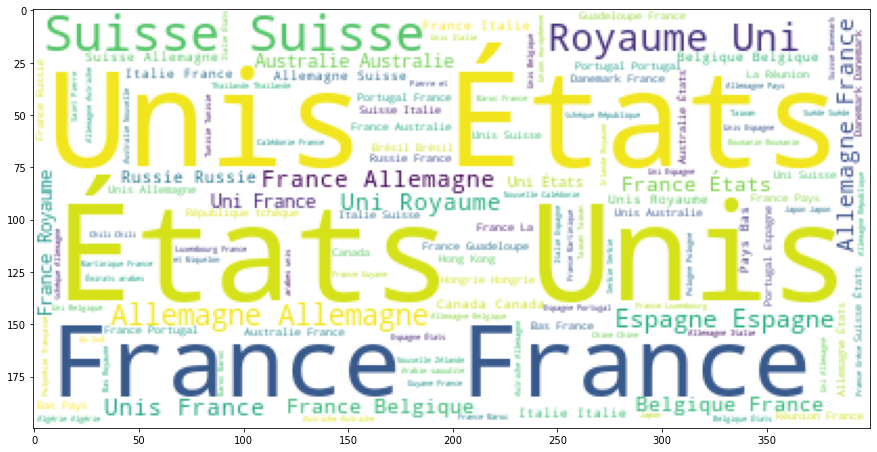

In [131]:
plot_words(df[~df.countries_fr.isna()], 'countries_fr')

### Repartition de `nutriscore_grade`

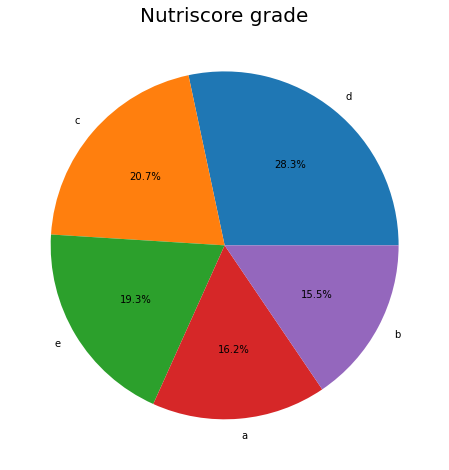

In [132]:
plt.figure(figsize=(15,8))
df_selected.nutrition_grade_fr.value_counts().plot.pie(autopct="%.1f%%");
plt.title('Nutriscore grade', fontsize=20);
plt.ylabel('');

## Analyse bivarié

In [416]:
df_selected.columns

Index(['creator', 'product_name', 'brands', 'countries_fr', 'ingredients_text',
       'serving_size', 'additives_n', 'ingredients_from_palm_oil_n',
       'ingredients_that_may_be_from_palm_oil_n', 'nutrition_grade_fr',
       'energy_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g',
       'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g',
       'sodium_100g', 'nutrition-score-fr_100g', 'nutrition-score-uk_100g',
       'fruits-vegetables-nuts_100g', 'additives_tags', 'creator_top5',
       'countries_fr_new'],
      dtype='object')

<AxesSubplot:xlabel='nutrition-score-fr_100g', ylabel='fat_100g'>

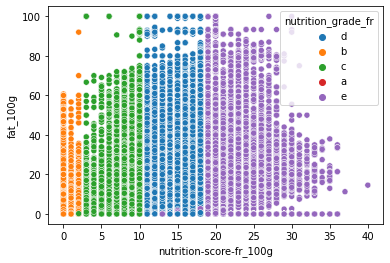

In [417]:
sns.scatterplot(data=df_selected, x="nutrition-score-fr_100g", y="fat_100g", hue="nutrition_grade_fr")

<AxesSubplot:xlabel='nutrition-score-fr_100g', ylabel='sodium_100g'>

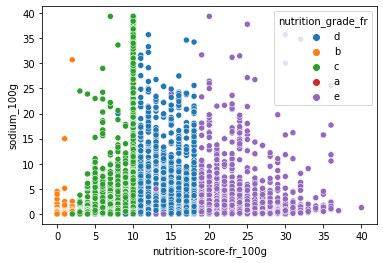

In [418]:
sns.scatterplot(data=df_selected, x="nutrition-score-fr_100g", y="sodium_100g", hue="nutrition_grade_fr")

<AxesSubplot:xlabel='nutrition-score-fr_100g', ylabel='fat_100g'>

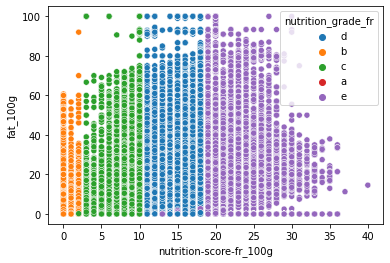

In [419]:
sns.scatterplot(data=df_selected, x="nutrition-score-fr_100g", y="fat_100g", hue="nutrition_grade_fr")

<AxesSubplot:xlabel='additives_n', ylabel='energy_100g'>

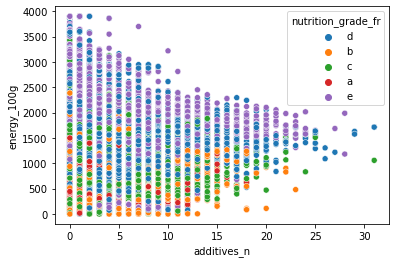

In [428]:
sns.scatterplot(data=df_selected, x="additives_n", y="energy_100g", hue="nutrition_grade_fr")

<AxesSubplot:xlabel='fat_100g', ylabel='energy_100g'>

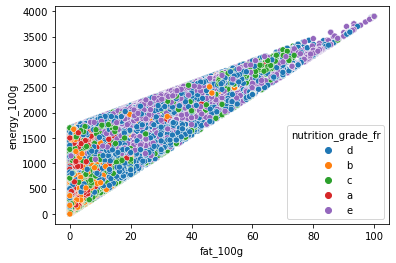

In [431]:
sns.scatterplot(data=df_selected, x="fat_100g", y="energy_100g", hue="nutrition_grade_fr")

<AxesSubplot:xlabel='saturated-fat_100g', ylabel='energy_100g'>

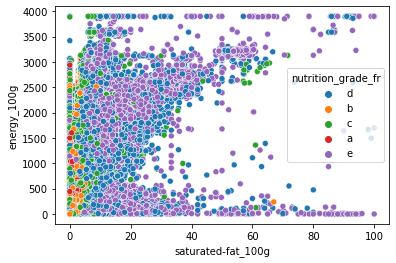

In [432]:
sns.scatterplot(data=df_selected, x="saturated-fat_100g", y="energy_100g", hue="nutrition_grade_fr")

<AxesSubplot:xlabel='carbohydrates_100g', ylabel='energy_100g'>

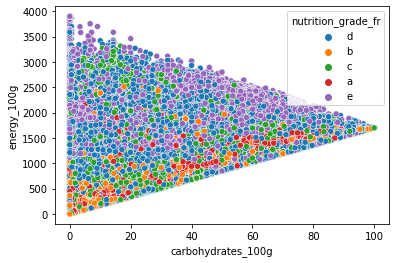

In [433]:
sns.scatterplot(data=df_selected, x="carbohydrates_100g", y="energy_100g", hue="nutrition_grade_fr")

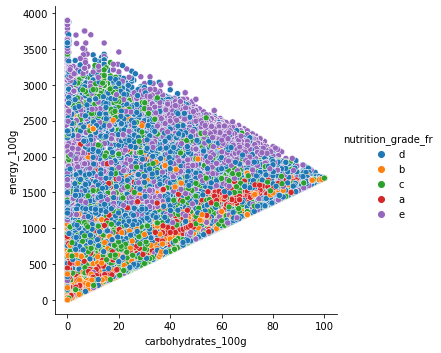

In [437]:
sns.relplot(data=df_selected, x="carbohydrates_100g", y="energy_100g", hue="nutrition_grade_fr")

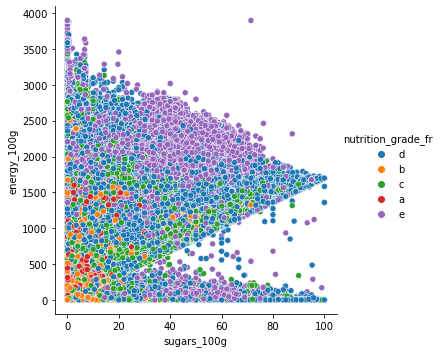

In [438]:
sns.relplot(data=df_selected, x="sugars_100g", y="energy_100g", hue="nutrition_grade_fr")

<AxesSubplot:xlabel='nutrition_grade_fr', ylabel='sugars_100g'>

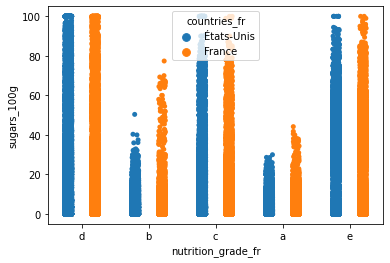

In [445]:
sns.stripplot(x="nutrition_grade_fr", y="sugars_100g", data=df_selected[(df_selected.countries_fr=='France') | (df_selected.countries_fr=='États-Unis')], hue="countries_fr", dodge=True)

<AxesSubplot:xlabel='nutrition_grade_fr', ylabel='sugars_100g'>

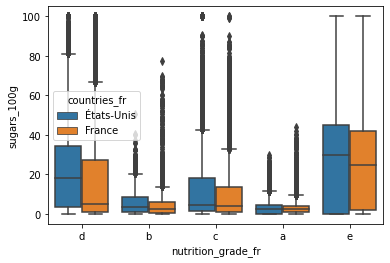

In [446]:
sns.boxplot(x="nutrition_grade_fr", y="sugars_100g", data=df_selected[(df_selected.countries_fr=='France') | (df_selected.countries_fr=='États-Unis')], hue="countries_fr", dodge=True)

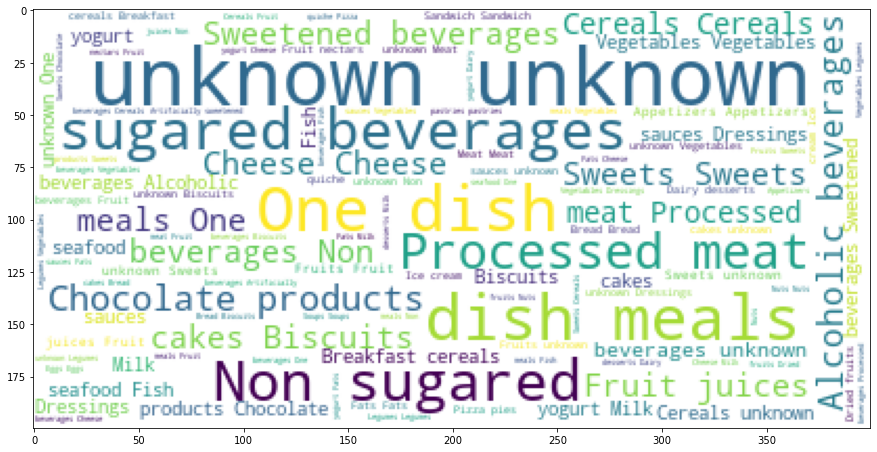

In [135]:
plot_words(df[~df.pnns_groups_2.isna()], 'pnns_groups_2')

In [156]:
compute_words_freq(df, 'category_fr', sep=',')

KeyError: 'category_fr'

# TODO: DEFINE WATER NOT WATER by regarding the serving size

# Faire une analyse exploratoire ACP

***ACP nous permet de:***
   - La variabilité entre les individus, c'est-à-dire quelles sont les différences et les ressemblances entre individus.
   - Les liaisons entre les variables : y a-t-il des groupes de variables très corrélées entre elles qui peuvent être regroupées en de nouvelles variables synthétiques ?

In [66]:
# selection des colonnes à prendre en compte dans l'ACP
columns_acp = []
for c in list(df_selected.columns):
    if c.endswith('_100g'):
        columns_acp.append(c)
df_pca = df_selected[columns_acp]

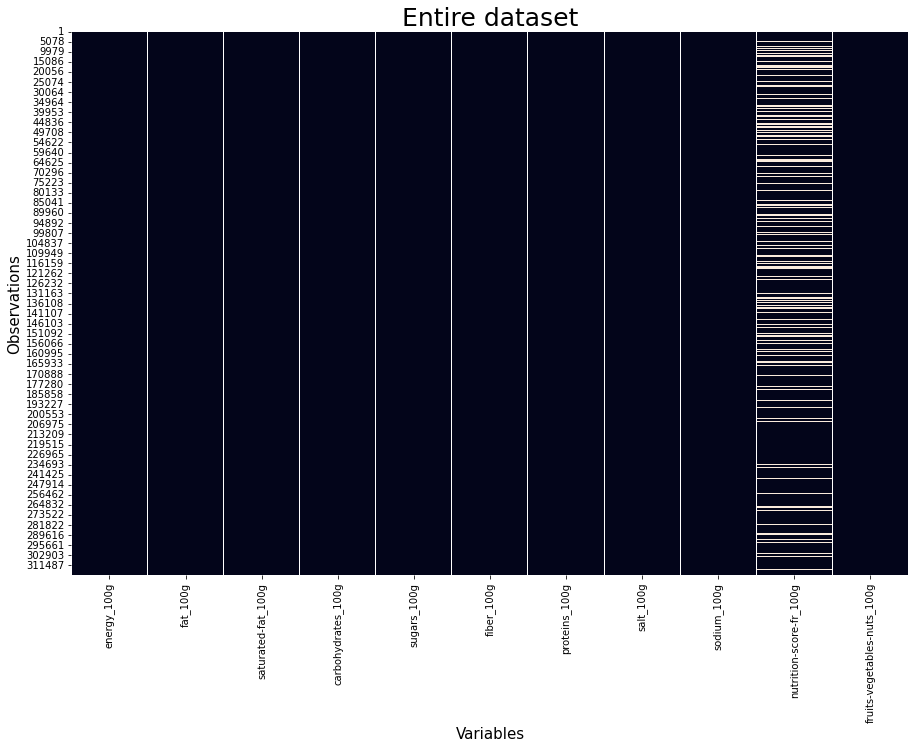

In [67]:
plot_data(df_pca)

In [72]:
# Preparation des données
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
X = np.array(df_pca['nutrition-score-fr_100g']).reshape(-1, 1)
imp.fit(X)
df_pca['nutrition-score-fr_100g'] = imp.transform(X)
#del X

SimpleImputer()

/Users/marius/opt/anaconda3/envs/oc3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [73]:
X = df_pca.values
names = df_pca.index #["product_name"] # ou data.index pour avoir les intitulés
features = df_pca.columns

# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

In [84]:
# choix du nombre de composantes à calculer
n_comp = 6

# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

X_projected = pca.fit_transform(X_scaled)


pd.DataFrame(X_projected, index = df_pca.index, columns = ['F{0}'.format(i) for i in range(n_comp)])

PCA(n_components=6)

,F0,F1,F2,F3,F4,F5
1,3.091860,0.072895,-0.235046,-0.375285,0.086794,-0.987256
2,0.721344,-0.505691,-0.053642,2.358090,0.089932,0.242799
3,2.645036,0.695390,-1.761799,1.401156,0.254924,-0.585710
4,0.168037,-0.691041,0.543464,1.489910,-0.048866,0.056737
5,1.194646,-0.476665,0.052304,1.861144,0.075296,0.021340
...,...,...,...,...,...,...
320756,0.195326,0.101400,-0.446975,-0.398300,-0.026414,-0.937226
320757,-1.050205,-0.191532,-1.638321,2.408875,0.101825,0.687737
320763,-2.089098,-0.365881,-0.565816,-0.664806,-0.183703,-0.452817
320768,-2.245772,-0.407792,-0.590992,-0.643012,-0.183594,-0.554301


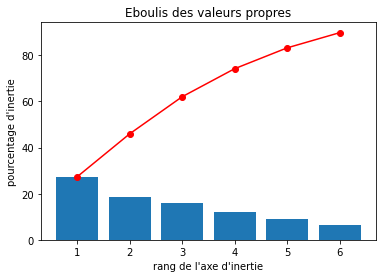

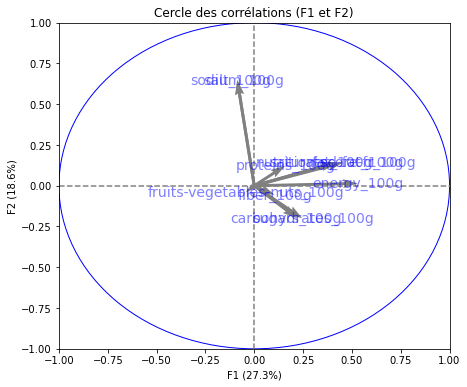

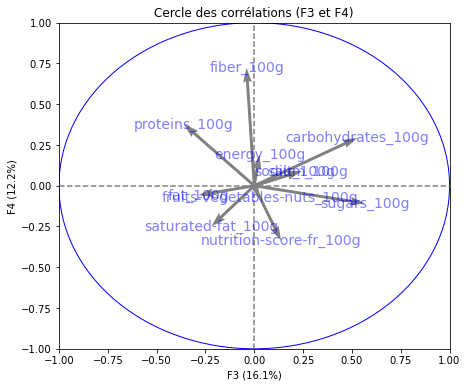

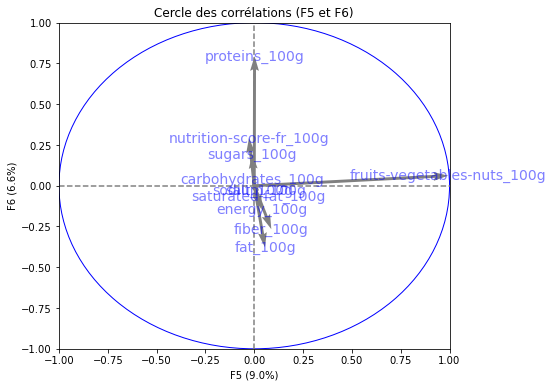

In [85]:
# Eboulis des valeurs propres
display_scree_plot(pca)

# Cercle des corrélations
pcs = pca.components_
display_circles(pcs, n_comp, pca, [(0,1),(2,3),(4,5)], labels = np.array(features))

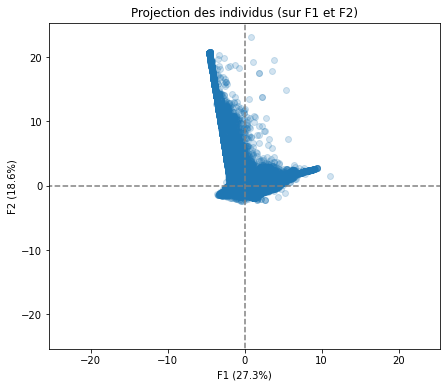

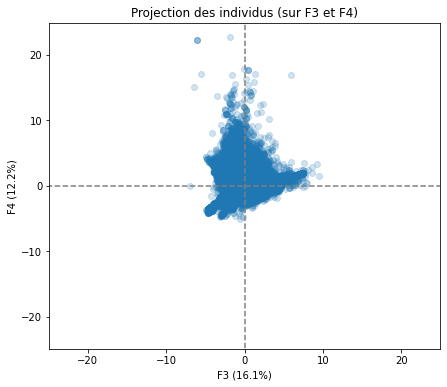

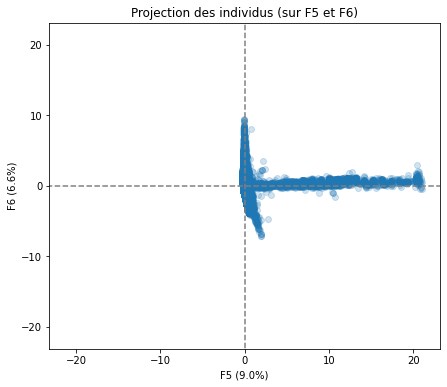

In [92]:
# Projection des individus
X_projected = pca.transform(X_scaled)
display_factorial_planes(X_projected, n_comp, pca, [(0,1),(2,3),(4,5)], alpha = 0.2)

# K-means algorithm

In [306]:
cols = ['energy_100g', 'fat_100g',  'saturated-fat_100g',
       'sugars_100g', 'fiber_100g', 'proteins_100g', 
       'sodium_100g', 'nutrition_grade_fr', ]
#'carbohydrates_100g','salt_100g', 'fruits-vegetables-nuts_100g', 'carbohydrates_100g'

df_selected_clustering = df_selected[cols]
df_selected_clustering = df_selected_clustering[~df_selected_clustering.nutrition_grade_fr.isna()]

clusters = df_selected_clustering['nutrition_grade_fr']
clusters = np.array(clusters.apply(lambda x: ord(x)-97)) # transformé en numeric
df_selected_clustering.drop('nutrition_grade_fr', inplace=True, axis=1)

# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(df_selected_clustering)
df_selected_clustering = std_scale.transform(df_selected_clustering)

In [307]:
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn import metrics

K = len(np.unique(clusters))
kmeans = KMeans(n_clusters=K).fit(df_selected_clustering)

metrics.rand_score(clusters, kmeans.labels_)

0.6695333497839833